# Navigation

---
In this notebook, we will learn how to control an agent in a more challenging environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893), where it can learn directly from raw pixels!

### 1. Start the Environment
We begin by importing some necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](https://numpy.org/) and [PyTorch](https://pytorch.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np                         
import torch
import random                              
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment! *__Before running the code cell below__*, change the file_name parameter to match the location of the Unity environment that you downloaded.

- __Mac:__ "path/to/VisualBanana.app"
- __Windows (x86):__ "path/to/VisualBanana_Windows_x86/Banana.exe"
- __Windows (x86_64):__ "path/to/VisualBanana_Windows_x86_64/Banana.exe"
- __Linux (x86):__ "path/to/VisualBanana_Linux/Banana.x86"
- __Linux (x86_64):__ "path/to/VisualBanana_Linux/Banana.x86_64"
- __Linux (x86, headless):__ "path/to/VisualBanana_Linux_NoVis/Banana.x86"
- __Linux (x86_64, headless):__ "path/to/VisualBanana_Linux_NoVis/Banana.x86_64"

For instance, if you are using a Mac, then you downloaded Banana.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

    env = UnityEnvironment(file_name="VisualBanana.app")

In [2]:
env = UnityEnvironment(file_name="")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:

- 0 - walk forward
- 1 - walk backward
- 2 - turn left
- 3 - turn right

The environment state is an array of raw pixels with shape (1, 84, 84, 3). A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


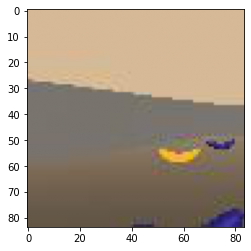

States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step. A window should pop up that allows you to observe the agent, as it moves through the environment.

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the scoreimport torch

while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. Define the preprocessing function

In the next code cell, we will define a function that collecting multiple consecutive frames (RGB images, corresponding to the agent's first-person view), stacking them together, and showing them to the agent as one state.

In [7]:
def stack_frames(stacked_frames, state, is_new_episode):
    """Collect and stack multiple consecutive frames (arrays of raw pixels) as one state.
    
    Params
    ======
        stacked_frames (deque object): list-like container with 3-D arrays of raw pixels
        state (ndarray): 4-D array of raw pixels with shape (1, 84, 84, 3)
        is_new_episode (bool): whether or not to use an input list-like container "stacked_frame" 
    """
    # 1,84,84,3 -> 84,84,3
    frame = np.squeeze(state)
    
    if is_new_episode:
        # clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84,3), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        # because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # join a sequence of frames along the first dimension
        stacked_state = np.stack(stacked_frames, axis=0)
        # transpose it into torch order (CDHW): 4,84,84,3 -> 3,4,84,84
        stacked_state = stacked_state.transpose((3, 0, 1, 2))
        # add a batch dimension (NCDHW) 
        stacked_state = np.expand_dims(stacked_state, axis=0)
    else:
        # append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=0)
        # transpose it into torch order (CDHW): 4,84,84,3 -> 3,4,84,84
        stacked_state = stacked_state.transpose((3, 0, 1, 2))
        # add a batch dimension (NCDHW) 
        stacked_state = np.expand_dims(stacked_state, axis=0)
    return stacked_state, stacked_frames

### 4. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**5. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [8]:
# check for GPU
print("CUDA is available:", torch.cuda.is_available())

# if gpu is to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set the seed for generating random numbers
seed = 0
torch.manual_seed(seed) # (both CPU and CUDA)
np.random.seed(seed)
random.seed(seed)

# number of RGB images (frames) to stack
stack_size = 4

from double_dqn_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, frames_num = stack_size)

CUDA is available: True


When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:

    env_info = env.reset(train_mode=True)[brain_name]

In [9]:
def dqn(n_episodes = 2000,
        max_t = 1000,
        eps_start = 1.0, 
        eps_end = 0.01, 
        eps_decay = 0.99,
        ):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                                                                           # list containing scores from each episode
    scores_window = deque(maxlen=100)                                                     # last 100 scores
    eps = eps_start                                                                       # initialize epsilon
    # Initialize deque with zero-images one array for each image
    stacked_frames = deque([np.zeros((84,84,3), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]                                 # reset the environment
        state = env_info.visual_observations[0]                                           # get the current state
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                                                # select an action
            env_info = env.step(int(action))[brain_name]                                  # send the action to the environment
            next_state = env_info.visual_observations[0]                                  # get the next state
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            reward = env_info.rewards[0]                                                  # get the reward
            done = env_info.local_done[0]                                                 # see if episode has finished 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:                                                                      # exit loop if episode finished
                break
        agent.scheduler.step()
        scores_window.append(score)                                                       # save most recent score
        scores.append(score)                                                              # save most recent score
        eps = max(eps_end, eps_decay*eps)                                                 # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

Episode 100	Average Score: 0.18
Episode 200	Average Score: 1.93
Episode 300	Average Score: 4.35
Episode 400	Average Score: 7.58
Episode 500	Average Score: 10.49
Episode 600	Average Score: 11.20
Episode 678	Average Score: 13.10
Environment solved in 578 episodes!	Average Score: 13.10


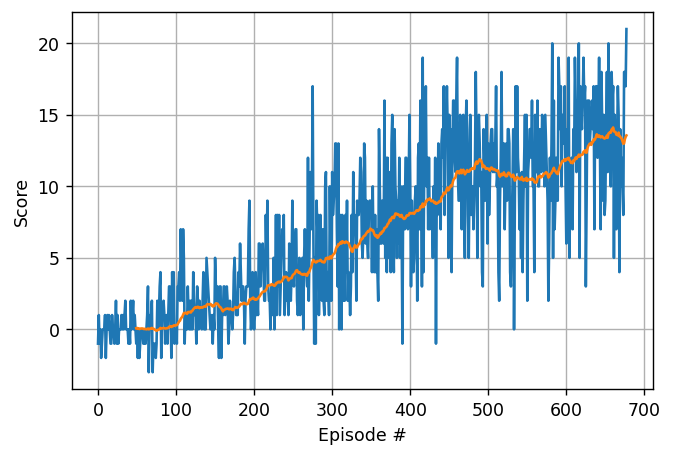

In [10]:
import pandas as pd

def plot_scores(scores, rolling_window=50):
    """Plot scores and rolling mean using specified window."""
    plt.figure(dpi=125)
    plt.plot(scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.grid()
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)

# plot the scores
plot = plot_scores(scores)

### 5. Watch a Smart Agent!

In [11]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

stacked_frames = deque([np.zeros((84,84,3), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

for i_episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]                                  # reset the environment
    state = env_info.visual_observations[0]                                             # get the current state
    stacked_frames = deque([np.zeros((84,84,3), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    score = 0                                                                           # initialize the score
    while True:
        action = agent.act(state)                                                       # select an action
        env_info = env.step(int(action))[brain_name]                                    # send the action to the environment
        next_state = env_info.visual_observations[0]                                    # get the next state
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        reward = env_info.rewards[0]                                                    # get the reward
        done = env_info.local_done[0]                                                   # see if episode has finished
        score += reward                                                                 # update the score
        state = next_state                                                              # update the state
        if done:                                                                        # exit loop if episode finished
            break
    print("Score: {}".format(score))

Score: 13.0
Score: 13.0
Score: 16.0


When finished, close the environment.

In [12]:
env.close()